In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/drone-yolo-detection/yolov2-tiny-voc.cfg
/kaggle/input/drone-yolo-detection/Database1/Database1/video16_141.txt
/kaggle/input/drone-yolo-detection/Database1/Database1/video19_2971.JPEG
/kaggle/input/drone-yolo-detection/Database1/Database1/video19_3440.JPEG
/kaggle/input/drone-yolo-detection/Database1/Database1/video19_2645.txt
/kaggle/input/drone-yolo-detection/Database1/Database1/video17_1074.JPEG
/kaggle/input/drone-yolo-detection/Database1/Database1/video18_1262.txt
/kaggle/input/drone-yolo-detection/Database1/Database1/video18_1714.txt
/kaggle/input/drone-yolo-detection/Database1/Database1/name62.JPEG
/kaggle/input/drone-yolo-detection/Database1/Database1/video18_1119.txt
/kaggle/input/drone-yolo-detection/Database1/Database1/266.JPEG
/kaggle/input/drone-yolo-detection/Database1/Database1/video14_44.JPEG
/kaggle/input/drone-yolo-detection/Database1/Database1/video18_2213.JPEG
/kaggle/input/drone-yolo-detection/Database1/Database1/video17_113.JPEG
/kaggle/input/drone-

# General imports

In [2]:
import torch 
import torch.nn as nn 
import torch.optim as optim 
  
from PIL import Image, ImageFile 
ImageFile.LOAD_TRUNCATED_IMAGES = True
  
import albumentations as A 
from albumentations.pytorch import ToTensorV2 
import cv2 
  
import os 
import numpy as np 
import pandas as pd 
  
import matplotlib.pyplot as plt 
import matplotlib.patches as patches 
import warnings
from tqdm import tqdm

# Helper functions <br> Intersection Over union

In [3]:
def iou(box1, box2, is_pred=True):
    
    if is_pred:
        # IoU score for prediction and label 
        # box1 (prediction) and box2 (label) are both in [x, y, width, height] format 
        # Box coordinates of prediction 
        b1_x1 = box1[..., 0:1] - box1[..., 2:3] / 2
        b1_y1 = box1[..., 1:2] - box1[..., 3:4] / 2
        b1_x2 = box1[..., 0:1] + box1[..., 2:3] / 2
        b1_y2 = box1[..., 1:2] + box1[..., 3:4] / 2

        # Box coordinates of ground truth 
        b2_x1 = box2[..., 0:1] - box2[..., 2:3] / 2
        b2_y1 = box2[..., 1:2] - box2[..., 3:4] / 2
        b2_x2 = box2[..., 0:1] + box2[..., 2:3] / 2
        b2_y2 = box2[..., 1:2] + box2[..., 3:4] / 2

        # Get the coordinates of the intersection rectangle 
        x1 = torch.max(b1_x1, b2_x1) 
        y1 = torch.max(b1_y1, b2_y1) 
        x2 = torch.min(b1_x2, b2_x2) 
        y2 = torch.min(b1_y2, b2_y2) 
        
        # Make sure the intersection is at least 0 
        intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0) 

        # Calculate the union area 
        box1_area = (b1_x2 - b1_x1) * (b1_y2 - b1_y1) 
        box2_area = (b2_x2 - b2_x1) * (b2_y2 - b2_y1) 
        union = box1_area + box2_area - intersection 

        # Calculate the IoU score 
        epsilon = 1e-6
        iou_score = intersection / (union + epsilon) 

        return iou_score
    
    else:
    
        # If `is_pred` is False, box1 and box2 are in [width, height] format
        # Calculate intersection and union for single box vs. multiple anchors
        box1 = box1.unsqueeze(0)  # Make box1 a 2D tensor
        if box2.dim() == 1:
            box2 = box2.unsqueeze(0)

        # Calculate intersection coordinates
        inter_w = torch.min(box1[:, 0], box2[:, 0])
        inter_h = torch.min(box1[:, 1], box2[:, 1])
        union_w = torch.max(box1[:, 0], box2[:, 0])
        union_h = torch.max(box1[:, 1], box2[:, 1])

        # Ensure width and height are positive
        inter_w = inter_w.clamp(0)
        inter_h = inter_h.clamp(0)

        # Calculate intersection and union areas
        intersection = inter_w * inter_h
        box1_area = box1[:, 0] * box1[:, 1]
        box2_area = box2[:, 0] * box2[:, 1]
        union = box1_area + box2_area - intersection

        # Calculate IoU
        epsilon = 1e-6
        iou_score = intersection / (union + epsilon)

        return iou_score


# NMS Function

In [4]:
# Non-maximum suppression function to remove overlapping bounding boxes 
def nms(bboxes, iou_threshold, threshold): 
    # Filter out bounding boxes with confidence below the threshold. 
    bboxes = [box for box in bboxes if box[1] > threshold] 

    # Sort the bounding boxes by confidence in descending order. 
    bboxes = sorted(bboxes, key=lambda x: x[1], reverse=True) 

    # Initialize the list of bounding boxes after non-maximum suppression. 
    bboxes_nms = [] 

    while bboxes: 
        # Get the first bounding box. 
        first_box = bboxes.pop(0) 

        # Iterate over the remaining bounding boxes. 
        for box in bboxes: 
        # If the bounding boxes do not overlap or if the first bounding box has 
        # a higher confidence, then add the second bounding box to the list of 
        # bounding boxes after non-maximum suppression. 
            if box[0] != first_box[0] or iou( 
                torch.tensor(first_box[2:]), 
                torch.tensor(box[2:]), 
            ) < iou_threshold: 
                # Check if box is not in bboxes_nms 
                if box not in bboxes_nms: 
                    # Add box to bboxes_nms 
                    bboxes_nms.append(box) 

    # Return bounding boxes after non-maximum suppression. 
    return bboxes_nms


# Cells to Bounding Boxes

In [5]:
# Function to convert cells to bounding boxes 
def convert_cells_to_bboxes(predictions, anchors, s, is_predictions=True): 
    # Batch size used on predictions 
    batch_size = predictions.shape[0] 
    # Number of anchors 
    num_anchors = len(anchors) 
    # List of all the predictions 
    box_predictions = predictions[..., 1:5] 

    # If the input is predictions then we will pass the x and y coordinate 
    # through sigmoid function and width and height to exponent function and 
    # calculate the score and best class. 
    if is_predictions: 
        anchors = anchors.reshape(1, len(anchors), 1, 1, 2) 
        box_predictions[..., 0:2] = torch.sigmoid(box_predictions[..., 0:2]) 
        box_predictions[..., 2:] = torch.exp( 
            box_predictions[..., 2:]) * anchors 
        scores = torch.sigmoid(predictions[..., 0:1]) 
        best_class = torch.argmax(predictions[..., 5:], dim=-1).unsqueeze(-1) 

    # Else we will just calculate scores and best class. 
    else: 
        scores = predictions[..., 0:1] 
        best_class = predictions[..., 5:6] 

    # Calculate cell indices 
    cell_indices = ( 
        torch.arange(s) 
        .repeat(predictions.shape[0], 3, s, 1) 
        .unsqueeze(-1) 
        .to(predictions.device) 
    ) 

    # Calculate x, y, width and height with proper scaling 
    x = 1 / s * (box_predictions[..., 0:1] + cell_indices) 
    y = 1 / s * (box_predictions[..., 1:2] +
                cell_indices.permute(0, 1, 3, 2, 4)) 
    width_height = 1 / s * box_predictions[..., 2:4] 

    # Concatinating the values and reshaping them in 
    # (BATCH_SIZE, num_anchors * S * S, 6) shape 
    converted_bboxes = torch.cat( 
        (best_class, scores, x, y, width_height), dim=-1
    ).reshape(batch_size, num_anchors * s * s, 6) 

    # Returning the reshaped and converted bounding box list 
    return converted_bboxes.tolist()


# plot the image function

In [6]:
# Function to plot images with bounding boxes and class labels 
def plot_image(image, boxes): 
    # Getting the color map from matplotlib 
    colour_map = plt.get_cmap("tab20b") 
    # Getting 20 different colors from the color map for 20 different classes 
    colors = [colour_map(i) for i in np.linspace(0, 1, len(class_labels))] 

    # Reading the image with OpenCV 
    img = np.array(image) 
    # Getting the height and width of the image 
    h, w, _ = img.shape 

    # Create figure and axes 
    fig, ax = plt.subplots(1 , figsize=(12,12)) 

    # Add image to plot 
    ax.imshow(img) 

    # Plotting the bounding boxes and labels over the image 
    for box in boxes: 
        # Get the class from the box 
        class_pred = box[0] 
        # Get the center x and y coordinates 
        box = box[2:] 
        # Get the upper left corner coordinates 
        upper_left_x = box[0] - box[2] / 2
        upper_left_y = box[1] - box[3] / 2

        # Create a Rectangle patch with the bounding box 
        rect = patches.Rectangle( 
            (upper_left_x * w, upper_left_y * h), 
            box[2] * w, 
            box[3] * h, 
            linewidth=2, 
            edgecolor=colors[int(class_pred)], 
            facecolor="none", 
        ) 

        # Add the patch to the Axes 
        ax.add_patch(rect) 

        # Add class name to the patch 
        plt.text( 
            upper_left_x * w, 
            upper_left_y * h, 
            s=class_labels[int(class_pred)], 
            color="white", 
            verticalalignment="top", 
            bbox={"color": colors[int(class_pred)], "pad": 0}, 
        ) 

    # Display the plot 
    plt.show()


# Save the checkpoint function

In [7]:
# Function to save checkpoint 
def save_checkpoint(model, optimizer, filename="my_checkpoint.pth.tar"): 
    print("==> Saving checkpoint") 
    checkpoint = { 
        "state_dict": model.state_dict(), 
        "optimizer": optimizer.state_dict(), 
    } 
    torch.save(checkpoint, filename)


# load the check point function

In [8]:
# Function to load checkpoint 
def load_checkpoint(checkpoint_file, model, optimizer, lr): 
    print("==> Loading checkpoint") 
    checkpoint = torch.load(checkpoint_file, map_location=device) 
    model.load_state_dict(checkpoint["state_dict"]) 
    optimizer.load_state_dict(checkpoint["optimizer"]) 

    for param_group in optimizer.param_groups: 
        param_group["lr"] = lr 


# Define constant

In [9]:
# Device 
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load and save model variable 
load_model = False
save_model = True

# model checkpoint file name 
checkpoint_file = "checkpoint.pth.tar"

# Anchor boxes for each feature map scaled between 0 and 1 
# 3 feature maps at 3 different scales based on YOLOv3 paper 
ANCHORS = [ 
    [(0.28, 0.22), (0.38, 0.48), (0.9, 0.78)], 
    [(0.07, 0.15), (0.15, 0.11), (0.14, 0.29)], 
    [(0.02, 0.03), (0.04, 0.07), (0.08, 0.06)], 
] 

# Batch size for training 
batch_size = 8

# Learning rate for training 
leanring_rate = 1e-5

# Number of epochs for training 
epochs = 20

# Image size 
image_size = 416

# Grid cell sizes 
s = [image_size // 32, image_size // 16, image_size // 8] 

# Class labels 
class_labels = ["drone"]


# DataLoader

In [10]:
import torch
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches



class Dataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, anchors, 
                 image_size=416, grid_sizes=[13, 26, 52], 
                 num_classes=1, transform=None):
        """
        Dataset class to load images and labels for object detection.

        Args:
            data_dir (str): Path to the data directory.
            anchors (list of lists): Anchor boxes for the scales.
            image_size (int): Size to which images are resized.
            grid_sizes (list): Sizes of the grid for different scales.
            num_classes (int): Number of object classes.
            transform (callable, optional): Optional transformation function.
        """
        self.image_size = image_size
        self.transform = transform
        self.grid_sizes = grid_sizes
        self.anchors = torch.tensor(anchors[0] + anchors[1] + anchors[2])
        self.num_anchors = self.anchors.shape[0]
        self.num_anchors_per_scale = self.num_anchors // 3
        self.num_classes = num_classes
        self.ignore_iou_thresh = 0.5
        
        self.data_dir = data_dir
        
        # Load the images and labels
        self.image_files = [f for f in os.listdir(self.data_dir) if f.endswith(('.JPEG'))]
        self.label_files = [f for f in os.listdir(self.data_dir) if f.endswith('.txt')]
        
        # Ensure label files have corresponding images and contain valid data
        self.image_label_pairs = []
        for img_file in self.image_files:
            label_file = img_file.rsplit('.', 1)[0] + '.txt'
            if label_file in self.label_files:
                # Check if the label file is non-empty
                label_path = os.path.join(self.data_dir, label_file)
                if self.is_valid_label_file(label_path):
                    self.image_label_pairs.append((img_file, label_file))

        print(f"Number of valid image-label pairs: {len(self.image_label_pairs)}")  # Debug line

    def __len__(self):
        return len(self.image_label_pairs)

    def __getitem__(self, idx):
        img_name, label_name = self.image_label_pairs[idx]
        img_path = os.path.join(self.data_dir, img_name)
        label_path = os.path.join(self.data_dir, label_name)
        

        try:
            image = np.array(Image.open(img_path).convert("RGB"))
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            # Return a dummy image and empty targets if image loading fails
            return np.zeros((self.image_size, self.image_size, 3)), (torch.zeros_like(torch.tensor([])),)

        try:
            bboxes = np.roll(np.loadtxt(fname=label_path, delimiter=" ", ndmin=2), 4, axis=1).tolist()
        except Exception as e:
            print(f"Error loading label file {label_path}: {e}")
            # Return a dummy image or skip this sample
            return np.zeros((self.image_size, self.image_size, 3)), (torch.zeros_like(torch.tensor([])),)


        if self.transform:
            augs = self.transform(image=image, bboxes=bboxes)
            image = augs["image"]
            bboxes = augs["bboxes"]
    
        targets = [torch.zeros((self.num_anchors_per_scale, s, s, 6)) for s in self.grid_sizes]

        for box in bboxes:
            iou_anchors = iou(torch.tensor(box[2:4]), self.anchors, is_pred=False)
            anchor_indices = iou_anchors.argsort(descending=True, dim=0)
            x, y, width, height, class_label = box

            has_anchor = [False] * 3
            for anchor_idx in anchor_indices:
                scale_idx = anchor_idx // self.num_anchors_per_scale
                anchor_on_scale = anchor_idx % self.num_anchors_per_scale
                s = self.grid_sizes[scale_idx]
                i, j = int(s * y), int(s * x)
                anchor_taken = targets[scale_idx][anchor_on_scale, i, j, 0]

                if not anchor_taken and not has_anchor[scale_idx]:
                    targets[scale_idx][anchor_on_scale, i, j, 0] = 1
                    x_cell, y_cell = s * x - j, s * y - i
                    width_cell, height_cell = (width * s, height * s)
                    box_coordinates = torch.tensor([x_cell, y_cell, width_cell, height_cell])
                    targets[scale_idx][anchor_on_scale, i, j, 1:5] = box_coordinates
                    targets[scale_idx][anchor_on_scale, i, j, 5] = int(class_label)
                    has_anchor[scale_idx] = True

                elif not anchor_taken and iou_anchors[anchor_idx] > self.ignore_iou_thresh:
                    targets[scale_idx][anchor_on_scale, i, j, 0] = -1

        return image, tuple(targets)
    
    def is_valid_label_file(self, label_path):
        """
        Check if a label file is valid.

        Args:
            label_path (str): Path to the label file.

        Returns:
            bool: True if valid, False otherwise.
        """
        try:
            # Read label file and check if it has content
            bboxes = np.loadtxt(label_path, delimiter=" ", ndmin=2)
            # Check if each line has at least 5 columns (x, y, width, height, class_label)
            return bboxes.shape[1] >= 5
        except Exception as e:
            print(f"Error validating label file {label_path}: {e}")
            return False
        





# Data Transformation

In [11]:
# Transform for training 
train_transform = A.Compose( 
    [ 
        # Rescale an image so that maximum side is equal to image_size 
        A.LongestMaxSize(max_size=image_size), 
        # Pad remaining areas with zeros 
        A.PadIfNeeded( 
            min_height=image_size, min_width=image_size, border_mode=cv2.BORDER_CONSTANT 
        ), 
        # Random color jittering 
        A.ColorJitter( 
            brightness=0.5, contrast=0.5, 
            saturation=0.5, hue=0.5, p=0.5
        ), 
        # Flip the image horizontally 
        A.HorizontalFlip(p=0.5), 
        # Normalize the image 
        A.Normalize( 
            mean=[0, 0, 0], std=[1, 1, 1], max_pixel_value=255
        ), 
        # Convert the image to PyTorch tensor 
        ToTensorV2() 
    ], 
    # Augmentation for bounding boxes 
    bbox_params=A.BboxParams( 
                    format="yolo", 
                    min_visibility=0.4, 
                    label_fields=[] 
                ) 
    ) 

# Transform for testing 
test_transform = A.Compose( 
    [ 
        # Rescale an image so that maximum side is equal to image_size 
        A.LongestMaxSize(max_size=image_size), 
        # Pad remaining areas with zeros 
        A.PadIfNeeded( 
            min_height=image_size, min_width=image_size, border_mode=cv2.BORDER_CONSTANT 
        ), 
        # Normalize the image 
        A.Normalize( 
            mean=[0, 0, 0], std=[1, 1, 1], max_pixel_value=255
        ), 
        # Convert the image to PyTorch tensor 
        ToTensorV2() 
    ], 
    # Augmentation for bounding boxes 
    bbox_params=A.BboxParams( 
                    format="yolo", 
                    min_visibility=0.4, 
                    label_fields=[] 
                ) 
    )


In [12]:
import os

# Path of the directory to create
dir_path = '/kaggle/working/new_dataset'

# Create directory
os.makedirs(dir_path, exist_ok=True)

In [13]:
import os
import shutil
import cv2

def move_image_and_label(image_path, label_path, dest_folder):
    if not os.path.exists(dest_folder):
        os.makedirs(dest_folder)
    
    # Define destination paths
    dest_image_path = os.path.join(dest_folder, os.path.basename(image_path))
    dest_label_path = os.path.join(dest_folder, os.path.basename(label_path))
    
    # Check if files already exist
    if not os.path.exists(dest_image_path):
        # Move image
        shutil.copy(image_path, dest_image_path)
    else:
        print(f"Image already exists: {dest_image_path}")

    if os.path.exists(label_path) and not os.path.exists(dest_label_path):
        # Move label
        shutil.copy(label_path, dest_label_path)
    else:
        print(f"Label file not found or already exists: {label_path}")

def main(src_folder, dest_folder):
    for filename in os.listdir(src_folder):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(src_folder, filename)
            label_path = os.path.join(src_folder, filename.rsplit('.', 1)[0] + '.txt')
            
            # Try to open the image using OpenCV
            img = cv2.imread(image_path)
            if img is not None:
                # Move image and label to destination folder
                move_image_and_label(image_path, label_path, dest_folder)
                print(f"Processed: {filename}")
            else:
                print(f"Failed to open image: {image_path}")

if __name__ == "__main__":
    # Replace with your source and destination folders
    source_folder = '/kaggle/input/drone-yolo-detection/Database1/Database1'
    destination_folder = '/kaggle/working/new_dataset'
    main(source_folder, destination_folder)

Processed: video19_2971.JPEG
Processed: video19_3440.JPEG
Processed: video17_1074.JPEG
Processed: name62.JPEG
Processed: 266.JPEG
Processed: video14_44.JPEG
Processed: video18_2213.JPEG
Processed: video17_113.JPEG
Processed: video18_1392.JPEG
Processed: 14.JPEG
Processed: 55.JPEG
Processed: name25.JPEG
Processed: 344.JPEG
Processed: video15_413.JPEG
Processed: name6.JPEG
Processed: video18_1135.JPEG
Processed: video18_1339.JPEG
Processed: 228.JPEG
Processed: video19_2625.JPEG
Processed: video421.JPEG
Processed: video18_2587.JPEG
Processed: video17_1260.JPEG
Processed: video16_705.JPEG
Processed: video18_1724.JPEG
Processed: video17_1268.JPEG
Processed: video18_2990.JPEG
Processed: video19_2507.JPEG
Processed: video18_2086.JPEG
Processed: video16_447.JPEG
Processed: video16_402.JPEG
Processed: video16_357.JPEG
Processed: video19_2635.JPEG
Processed: video511.JPEG
Processed: video17_93.JPEG
Processed: video18_694.JPEG
Processed: video16_537.JPEG
Processed: video19_972.JPEG
Processed: vid

Premature end of JPEG file


Processed: video17_152.JPEG
Processed: video10244.JPEG
Processed: video1096.JPEG
Processed: video16_509.JPEG
Processed: 322.JPEG
Processed: video16_221.JPEG
Processed: video18_1406.JPEG
Processed: video18_1413.JPEG
Processed: video14_147.JPEG
Processed: video17_122.JPEG
Processed: video14_137.JPEG
Processed: video19_938.JPEG
Processed: video17_130.JPEG
Processed: video18_1481.JPEG
Processed: video16_381.JPEG
Processed: name18.JPEG
Processed: name11.JPEG
Processed: 142.JPEG
Processed: video16_124.JPEG
Processed: video19_2490.JPEG
Processed: video18_1928.JPEG
Processed: video18_1178.JPEG
Processed: video14_64.JPEG
Processed: video18_2728.JPEG
Processed: video19_1898.JPEG
Processed: video18_1833.JPEG
Processed: video18_1040.JPEG
Processed: 295.JPEG
Processed: video18_1889.JPEG
Processed: 64.JPEG
Processed: video14_164.JPEG
Processed: video18_2996.JPEG
Processed: video86.JPEG
Processed: 157.JPEG
Processed: video17_298.JPEG
Processed: video15_415.JPEG
Processed: video14_47.JPEG
Processed: v

# Loading the dataset

/tmp/ipykernel_34/3563630920.py:122: UserWarning: loadtxt: input contained no data: "/kaggle/working/new_dataset/video17_899.txt"
  bboxes = np.loadtxt(label_path, delimiter=" ", ndmin=2)
/tmp/ipykernel_34/3563630920.py:122: UserWarning: loadtxt: input contained no data: "/kaggle/working/new_dataset/video19_907.txt"
  bboxes = np.loadtxt(label_path, delimiter=" ", ndmin=2)
/tmp/ipykernel_34/3563630920.py:122: UserWarning: loadtxt: input contained no data: "/kaggle/working/new_dataset/video13121.txt"
  bboxes = np.loadtxt(label_path, delimiter=" ", ndmin=2)
/tmp/ipykernel_34/3563630920.py:122: UserWarning: loadtxt: input contained no data: "/kaggle/working/new_dataset/61.txt"
  bboxes = np.loadtxt(label_path, delimiter=" ", ndmin=2)
/tmp/ipykernel_34/3563630920.py:122: UserWarning: loadtxt: input contained no data: "/kaggle/working/new_dataset/video19_1918.txt"
  bboxes = np.loadtxt(label_path, delimiter=" ", ndmin=2)
/tmp/ipykernel_34/3563630920.py:122: UserWarning: loadtxt: input cont

Number of valid image-label pairs: 2863


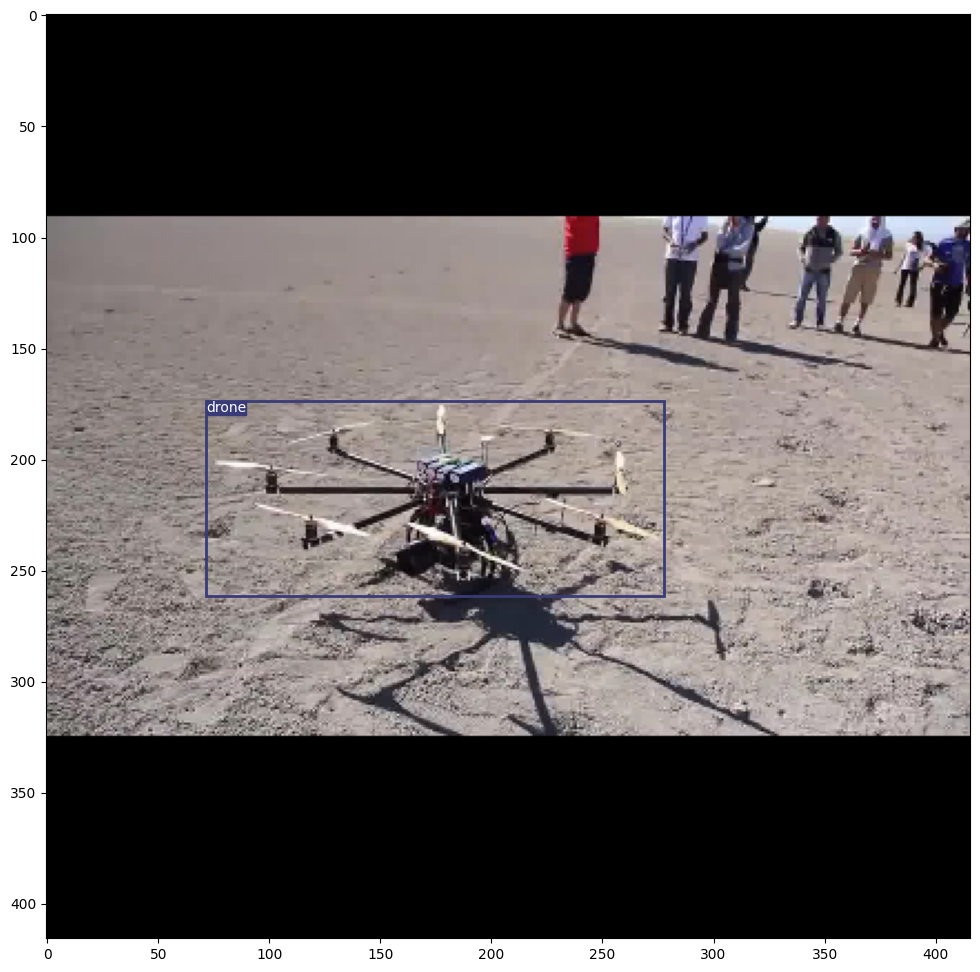

In [14]:
# Suppress specific warnings
warnings.filterwarnings("ignore", category=UserWarning, module="PIL.Image")

# Creating a dataset object 
dataset = Dataset( 
    data_dir="/kaggle/working/new_dataset/", 
    grid_sizes=[13, 26, 52], 
    anchors=ANCHORS, 
    transform=test_transform 
) 



# Creating a dataloader object 
loader = torch.utils.data.DataLoader( 
    dataset=dataset, 
    batch_size=4, 
    shuffle=True, 
) 

# Defining the grid size and the scaled anchors 
GRID_SIZE = [13, 26, 52] 
scaled_anchors = torch.tensor(ANCHORS) / ( 
    1 / torch.tensor(GRID_SIZE).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2) 
) 

# Getting a batch from the dataloader 
x, y = next(iter(loader)) 

# Getting the boxes coordinates from the labels 
# and converting them into bounding boxes without scaling 
boxes = [] 
for i in range(y[0].shape[1]): 
    anchor = scaled_anchors[i] 
    boxes += convert_cells_to_bboxes( 
            y[i], is_predictions=False, s=y[i].shape[2], anchors=anchor 
            )[0] 

# Applying non-maximum suppression 
boxes = nms(boxes, iou_threshold=1, threshold=0.7) 

# Plotting the image with the bounding boxes 
plot_image(x[0].permute(1,2,0).to("cpu"), boxes)


# Defining the CNN Block

In [15]:
# Defining CNN Block 
class CNNBlock(nn.Module): 
    def __init__(self, in_channels, out_channels, use_batch_norm=True, **kwargs): 
        super().__init__() 
        self.conv = nn.Conv2d(in_channels, out_channels, bias=not use_batch_norm, **kwargs) 
        self.bn = nn.BatchNorm2d(out_channels) 
        self.activation = nn.LeakyReLU(0.1) 
        self.use_batch_norm = use_batch_norm 
  
    def forward(self, x): 
        # Applying convolution 
        x = self.conv(x) 
        # Applying BatchNorm and activation if needed 
        if self.use_batch_norm: 
            x = self.bn(x) 
            return self.activation(x) 
        else: 
            return x

# Residual Block

In [16]:
# Defining residual block 
class ResidualBlock(nn.Module): 
    def __init__(self, channels, use_residual=True, num_repeats=1): 
        super().__init__() 

        # Defining all the layers in a list and adding them based on number of 
        # repeats mentioned in the design 
        res_layers = [] 
        for _ in range(num_repeats): 
            res_layers += [ 
                nn.Sequential( 
                    nn.Conv2d(channels, channels // 2, kernel_size=1), 
                    nn.BatchNorm2d(channels // 2), 
                    nn.LeakyReLU(0.1), 
                    nn.Conv2d(channels // 2, channels, kernel_size=3, padding=1), 
                    nn.BatchNorm2d(channels), 
                    nn.LeakyReLU(0.1) 
                ) 
            ] 
        self.layers = nn.ModuleList(res_layers) 
        self.use_residual = use_residual 
        self.num_repeats = num_repeats 

    # Defining forward pass 
    def forward(self, x): 
        for layer in self.layers: 
            residual = x 
            x = layer(x) 
            if self.use_residual: 
                x = x + residual 
        return x


# Scale the prediction block

In [17]:
# Defining scale prediction class 
class ScalePrediction(nn.Module): 
    def __init__(self, in_channels, num_classes): 
        super().__init__() 
        # Defining the layers in the network 
        self.pred = nn.Sequential( 
            nn.Conv2d(in_channels, 2*in_channels, kernel_size=3, padding=1), 
            nn.BatchNorm2d(2*in_channels), 
            nn.LeakyReLU(0.1), 
            nn.Conv2d(2*in_channels, (num_classes + 5) * 3, kernel_size=1), 
        ) 
        self.num_classes = num_classes 

    # Defining the forward pass and reshaping the output to the desired output 
    # format: (batch_size, 3, grid_size, grid_size, num_classes + 5) 
    def forward(self, x): 
        output = self.pred(x) 
        output = output.view(x.size(0), 3, self.num_classes + 5, x.size(2), x.size(3)) 
        output = output.permute(0, 1, 3, 4, 2) 
        return output


# YoloV3 Model

In [18]:
# Class for defining YOLOv3 model 
class YOLOv3(nn.Module): 
    def __init__(self, in_channels=3, num_classes=20): 
        super().__init__() 
        self.num_classes = num_classes 
        self.in_channels = in_channels 

        # Layers list for YOLOv3 
        self.layers = nn.ModuleList([ 
            CNNBlock(in_channels, 32, kernel_size=3, stride=1, padding=1), 
            CNNBlock(32, 64, kernel_size=3, stride=2, padding=1), 
            ResidualBlock(64, num_repeats=1), 
            CNNBlock(64, 128, kernel_size=3, stride=2, padding=1), 
            ResidualBlock(128, num_repeats=2), 
            CNNBlock(128, 256, kernel_size=3, stride=2, padding=1), 
            ResidualBlock(256, num_repeats=8), 
            CNNBlock(256, 512, kernel_size=3, stride=2, padding=1), 
            ResidualBlock(512, num_repeats=8), 
            CNNBlock(512, 1024, kernel_size=3, stride=2, padding=1), 
            ResidualBlock(1024, num_repeats=4), 
            CNNBlock(1024, 512, kernel_size=1, stride=1, padding=0), 
            CNNBlock(512, 1024, kernel_size=3, stride=1, padding=1), 
            ResidualBlock(1024, use_residual=False, num_repeats=1), 
            CNNBlock(1024, 512, kernel_size=1, stride=1, padding=0), 
            ScalePrediction(512, num_classes=num_classes), 
            CNNBlock(512, 256, kernel_size=1, stride=1, padding=0), 
            nn.Upsample(scale_factor=2), 
            CNNBlock(768, 256, kernel_size=1, stride=1, padding=0), 
            CNNBlock(256, 512, kernel_size=3, stride=1, padding=1), 
            ResidualBlock(512, use_residual=False, num_repeats=1), 
            CNNBlock(512, 256, kernel_size=1, stride=1, padding=0), 
            ScalePrediction(256, num_classes=num_classes), 
            CNNBlock(256, 128, kernel_size=1, stride=1, padding=0), 
            nn.Upsample(scale_factor=2), 
            CNNBlock(384, 128, kernel_size=1, stride=1, padding=0), 
            CNNBlock(128, 256, kernel_size=3, stride=1, padding=1), 
            ResidualBlock(256, use_residual=False, num_repeats=1), 
            CNNBlock(256, 128, kernel_size=1, stride=1, padding=0), 
            ScalePrediction(128, num_classes=num_classes) 
        ]) 

    # Forward pass for YOLOv3 with route connections and scale predictions 
    def forward(self, x): 
        outputs = [] 
        route_connections = [] 

        for layer in self.layers: 
            if isinstance(layer, ScalePrediction): 
                outputs.append(layer(x)) 
                continue
            x = layer(x) 

            if isinstance(layer, ResidualBlock) and layer.num_repeats == 8: 
                route_connections.append(x) 

            elif isinstance(layer, nn.Upsample): 
                x = torch.cat([x, route_connections[-1]], dim=1) 
                route_connections.pop() 
        return outputs


# Test the yolov3 Model

In [19]:
# Testing YOLO v3 model 
if __name__ == "__main__": 
    # Setting number of classes and image size 
    num_classes = 1
    IMAGE_SIZE = 416

    # Creating model and testing output shapes 
    model = YOLOv3(num_classes=num_classes) 
    x = torch.randn((1, 3, IMAGE_SIZE, IMAGE_SIZE)) 
    out = model(x) 
    print(out[0].shape) 
    print(out[1].shape) 
    print(out[2].shape) 

    # Asserting output shapes 
    assert model(x)[0].shape == (1, 3, IMAGE_SIZE//32, IMAGE_SIZE//32, num_classes + 5) 
    assert model(x)[1].shape == (1, 3, IMAGE_SIZE//16, IMAGE_SIZE//16, num_classes + 5) 
    assert model(x)[2].shape == (1, 3, IMAGE_SIZE//8, IMAGE_SIZE//8, num_classes + 5) 
    print("Output shapes are correct!")


torch.Size([1, 3, 13, 13, 6])
torch.Size([1, 3, 26, 26, 6])
torch.Size([1, 3, 52, 52, 6])
Output shapes are correct!


# Loss function

In [20]:
# Defining YOLO loss class 
class YOLOLoss(nn.Module): 
    def __init__(self): 
        super().__init__() 
        self.mse = nn.MSELoss() 
        self.bce = nn.BCEWithLogitsLoss() 
        self.cross_entropy = nn.CrossEntropyLoss() 
        self.sigmoid = nn.Sigmoid() 

    def forward(self, pred, target, anchors): 
        # Identifying which cells in target have objects 
        # and which have no objects 
        obj = target[..., 0] == 1
        no_obj = target[..., 0] == 0

        # Calculating No object loss 
        no_object_loss = self.bce( 
            (pred[..., 0:1][no_obj]), (target[..., 0:1][no_obj]), 
        ) 


        # Reshaping anchors to match predictions 
        anchors = anchors.reshape(1, 3, 1, 1, 2) 
        # Box prediction confidence 
        box_preds = torch.cat([self.sigmoid(pred[..., 1:3]), 
                            torch.exp(pred[..., 3:5]) * anchors 
                            ],dim=-1) 
        # Calculating intersection over union for prediction and target 
        ious = iou(box_preds[obj], target[..., 1:5][obj]).detach() 
        # Calculating Object loss 
        object_loss = self.mse(self.sigmoid(pred[..., 0:1][obj]), 
                            ious * target[..., 0:1][obj]) 


        # Predicted box coordinates 
        pred[..., 1:3] = self.sigmoid(pred[..., 1:3]) 
        # Target box coordinates 
        target[..., 3:5] = torch.log(1e-6 + target[..., 3:5] / anchors) 
        # Calculating box coordinate loss 
        box_loss = self.mse(pred[..., 1:5][obj], 
                            target[..., 1:5][obj]) 


        # Claculating class loss 
        class_loss = self.cross_entropy((pred[..., 5:][obj]), 
                                target[..., 5][obj].long()) 

        # Total loss 
        return ( 
            box_loss 
            + object_loss 
            + no_object_loss 
            + class_loss 
        )


# Training Loop

In [21]:
# Define the train function to train the model 
def training_loop(loader, model, optimizer, loss_fn, scaler, scaled_anchors): 
    # Creating a progress bar 
    progress_bar = tqdm(loader, leave=True) 

    # Initializing a list to store the losses 
    losses = [] 

    # Iterating over the training data 
    for _, (x, y) in enumerate(progress_bar): 
        x = x.to(device) 
        y0, y1, y2 = ( 
            y[0].to(device), 
            y[1].to(device), 
            y[2].to(device), 
        ) 
       
        with torch.cuda.amp.autocast(): 
            # Getting the model predictions 
            outputs = model(x) 
            # Calculating the loss at each scale 
            loss = ( 
                loss_fn(outputs[0], y0, scaled_anchors[0]) 
                + loss_fn(outputs[1], y1, scaled_anchors[1]) 
                + loss_fn(outputs[2], y2, scaled_anchors[2]) 
            ) 

        # Add the loss to the list 
        losses.append(loss.item()) 

        # Reset gradients 
        optimizer.zero_grad() 

        # Backpropagate the loss 
        scaler.scale(loss).backward() 

        # Optimization step 
        scaler.step(optimizer) 

        # Update the scaler for next iteration 
        scaler.update() 

        # update progress bar with loss 
        mean_loss = sum(losses) / len(losses) 
        progress_bar.set_postfix(loss=mean_loss)


# Model Training

In [22]:
# Creating the model from YOLOv3 class 
model = YOLOv3().to(device) 

# Defining the optimizer 
optimizer = optim.Adam(model.parameters(), lr = leanring_rate) 

# Defining the loss function 
loss_fn = YOLOLoss() 


# Defining the scaler for mixed precision training 
scaler = torch.cuda.amp.GradScaler() 

# Defining the train dataset 
train_dataset = Dataset( 
    data_dir="/kaggle/working/new_dataset", 
    anchors=ANCHORS, 
    transform=test_transform 
) 

# Defining the train data loader 
train_loader = torch.utils.data.DataLoader( 
    train_dataset, 
    batch_size = batch_size, 
    num_workers = 2, 
    shuffle = True, 
    pin_memory = True 
) 

# Scaling the anchors 
scaled_anchors = ( 
    torch.tensor(ANCHORS) *
    torch.tensor(s).unsqueeze(1).unsqueeze(1).repeat(1,3,2) 
).to(device) 

# Training the model 
for e in range(1, epochs+1): 
    print("Epoch:", e) 
    training_loop(train_loader, model, optimizer, loss_fn, scaler, scaled_anchors) 

    # Saving the model 
    if save_model: 
        save_checkpoint(model, optimizer, filename=f"checkpoint.pth.tar")


/tmp/ipykernel_34/3563630920.py:122: UserWarning: loadtxt: input contained no data: "/kaggle/working/new_dataset/video17_899.txt"
  bboxes = np.loadtxt(label_path, delimiter=" ", ndmin=2)
/tmp/ipykernel_34/3563630920.py:122: UserWarning: loadtxt: input contained no data: "/kaggle/working/new_dataset/video19_907.txt"
  bboxes = np.loadtxt(label_path, delimiter=" ", ndmin=2)
/tmp/ipykernel_34/3563630920.py:122: UserWarning: loadtxt: input contained no data: "/kaggle/working/new_dataset/video13121.txt"
  bboxes = np.loadtxt(label_path, delimiter=" ", ndmin=2)
/tmp/ipykernel_34/3563630920.py:122: UserWarning: loadtxt: input contained no data: "/kaggle/working/new_dataset/61.txt"
  bboxes = np.loadtxt(label_path, delimiter=" ", ndmin=2)
/tmp/ipykernel_34/3563630920.py:122: UserWarning: loadtxt: input contained no data: "/kaggle/working/new_dataset/video19_1918.txt"
  bboxes = np.loadtxt(label_path, delimiter=" ", ndmin=2)
/tmp/ipykernel_34/3563630920.py:122: UserWarning: loadtxt: input cont

Number of valid image-label pairs: 2863
Epoch: 1


100%|██████████| 358/358 [01:11<00:00,  4.98it/s, loss=4.66]


==> Saving checkpoint
Epoch: 2


100%|██████████| 358/358 [01:10<00:00,  5.11it/s, loss=1.62]


==> Saving checkpoint
Epoch: 3


100%|██████████| 358/358 [01:10<00:00,  5.05it/s, loss=1.15]


==> Saving checkpoint
Epoch: 4


100%|██████████| 358/358 [01:11<00:00,  5.02it/s, loss=0.892]


==> Saving checkpoint
Epoch: 5


100%|██████████| 358/358 [01:11<00:00,  5.00it/s, loss=0.718]


==> Saving checkpoint
Epoch: 6


100%|██████████| 358/358 [01:11<00:00,  4.99it/s, loss=0.601]


==> Saving checkpoint
Epoch: 7


100%|██████████| 358/358 [01:11<00:00,  4.99it/s, loss=0.507]


==> Saving checkpoint
Epoch: 8


100%|██████████| 358/358 [01:11<00:00,  4.99it/s, loss=0.439]


==> Saving checkpoint
Epoch: 9


100%|██████████| 358/358 [01:11<00:00,  4.99it/s, loss=0.381]


==> Saving checkpoint
Epoch: 10


100%|██████████| 358/358 [01:11<00:00,  4.98it/s, loss=0.335]


==> Saving checkpoint
Epoch: 11


100%|██████████| 358/358 [01:11<00:00,  4.99it/s, loss=0.3]  


==> Saving checkpoint
Epoch: 12


100%|██████████| 358/358 [01:11<00:00,  4.99it/s, loss=0.269]


==> Saving checkpoint
Epoch: 13


100%|██████████| 358/358 [01:11<00:00,  4.99it/s, loss=0.245]


==> Saving checkpoint
Epoch: 14


100%|██████████| 358/358 [01:11<00:00,  4.99it/s, loss=0.224]


==> Saving checkpoint
Epoch: 15


100%|██████████| 358/358 [01:11<00:00,  4.98it/s, loss=0.205]


==> Saving checkpoint
Epoch: 16


100%|██████████| 358/358 [01:11<00:00,  4.99it/s, loss=0.187]


==> Saving checkpoint
Epoch: 17


100%|██████████| 358/358 [01:11<00:00,  4.99it/s, loss=0.173]


==> Saving checkpoint
Epoch: 18


100%|██████████| 358/358 [01:11<00:00,  4.99it/s, loss=0.161]


==> Saving checkpoint
Epoch: 19


100%|██████████| 358/358 [01:11<00:00,  4.98it/s, loss=0.151]


==> Saving checkpoint
Epoch: 20


100%|██████████| 358/358 [01:11<00:00,  4.99it/s, loss=0.14] 


==> Saving checkpoint


# Testing the Model

==> Loading checkpoint


/tmp/ipykernel_34/3563630920.py:122: UserWarning: loadtxt: input contained no data: "/kaggle/working/new_dataset/video17_899.txt"
  bboxes = np.loadtxt(label_path, delimiter=" ", ndmin=2)
/tmp/ipykernel_34/3563630920.py:122: UserWarning: loadtxt: input contained no data: "/kaggle/working/new_dataset/video19_907.txt"
  bboxes = np.loadtxt(label_path, delimiter=" ", ndmin=2)
/tmp/ipykernel_34/3563630920.py:122: UserWarning: loadtxt: input contained no data: "/kaggle/working/new_dataset/video13121.txt"
  bboxes = np.loadtxt(label_path, delimiter=" ", ndmin=2)
/tmp/ipykernel_34/3563630920.py:122: UserWarning: loadtxt: input contained no data: "/kaggle/working/new_dataset/61.txt"
  bboxes = np.loadtxt(label_path, delimiter=" ", ndmin=2)
/tmp/ipykernel_34/3563630920.py:122: UserWarning: loadtxt: input contained no data: "/kaggle/working/new_dataset/video19_1918.txt"
  bboxes = np.loadtxt(label_path, delimiter=" ", ndmin=2)
/tmp/ipykernel_34/3563630920.py:122: UserWarning: loadtxt: input cont

Number of valid image-label pairs: 2863


/tmp/ipykernel_34/3563630920.py:122: UserWarning: loadtxt: input contained no data: "/kaggle/working/new_dataset/281.txt"
  bboxes = np.loadtxt(label_path, delimiter=" ", ndmin=2)
/tmp/ipykernel_34/3563630920.py:122: UserWarning: loadtxt: input contained no data: "/kaggle/working/new_dataset/video9238.txt"
  bboxes = np.loadtxt(label_path, delimiter=" ", ndmin=2)
/tmp/ipykernel_34/3563630920.py:122: UserWarning: loadtxt: input contained no data: "/kaggle/working/new_dataset/video16_713.txt"
  bboxes = np.loadtxt(label_path, delimiter=" ", ndmin=2)
/tmp/ipykernel_34/3563630920.py:122: UserWarning: loadtxt: input contained no data: "/kaggle/working/new_dataset/video524.txt"
  bboxes = np.loadtxt(label_path, delimiter=" ", ndmin=2)
/tmp/ipykernel_34/3563630920.py:122: UserWarning: loadtxt: input contained no data: "/kaggle/working/new_dataset/video19_2987.txt"
  bboxes = np.loadtxt(label_path, delimiter=" ", ndmin=2)
/tmp/ipykernel_34/3563630920.py:122: UserWarning: loadtxt: input contain

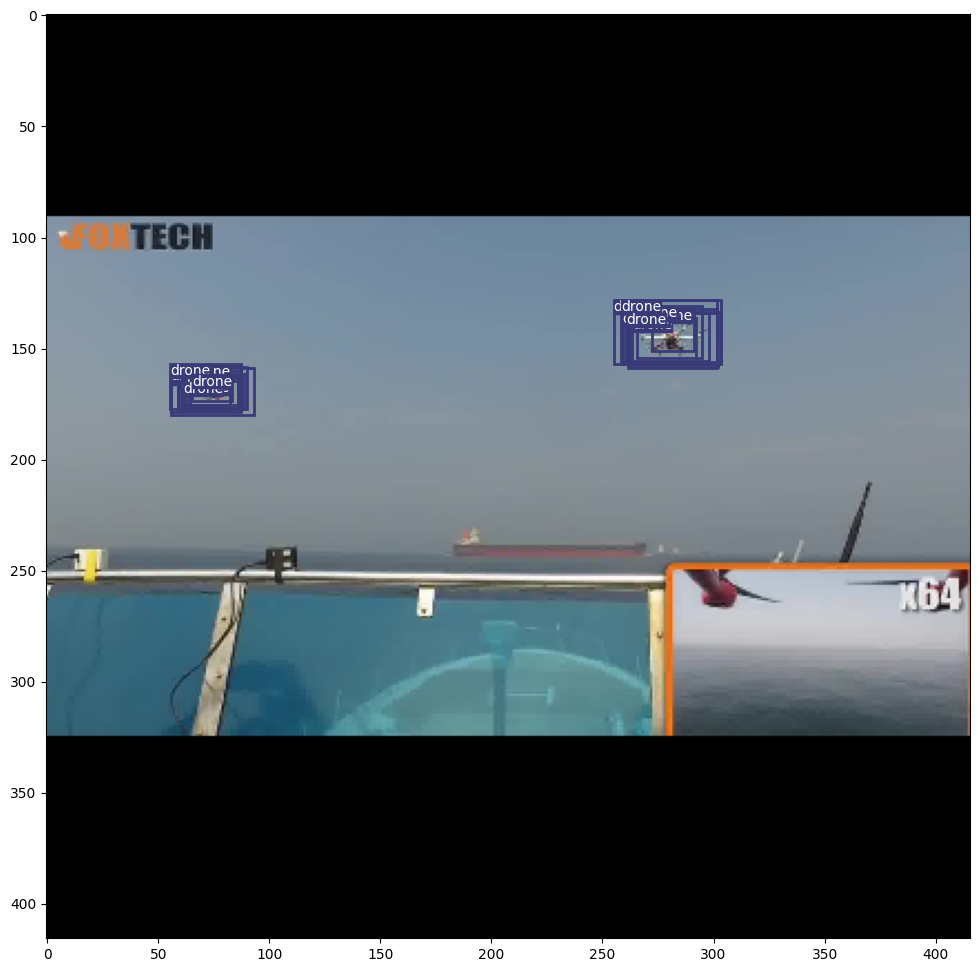

In [24]:
# Taking a sample image and testing the model 

# Setting the load_model to True 
load_model = True

# Defining the model, optimizer, loss function and scaler 
model = YOLOv3().to(device) 
optimizer = optim.Adam(model.parameters(), lr = leanring_rate) 
loss_fn = YOLOLoss() 
scaler = torch.cuda.amp.GradScaler() 

# Loading the checkpoint 
if load_model: 
    load_checkpoint(checkpoint_file, model, optimizer, leanring_rate) 

    # Defining the test dataset and data loader 
    test_dataset = Dataset( 
    data_dir="/kaggle/working/new_dataset/", 
    anchors=ANCHORS, 
    transform=test_transform 
) 
    test_loader = torch.utils.data.DataLoader( 
    test_dataset, 
    batch_size = 1, 
    num_workers = 2, 
    shuffle = True, 
) 

# Getting a sample image from the test data loader 
x, y = next(iter(test_loader)) 
x = x.to(device) 

model.eval() 
with torch.no_grad(): 
    # Getting the model predictions 
    output = model(x) 
    # Getting the bounding boxes from the predictions 
    bboxes = [[] for _ in range(x.shape[0])] 
    anchors = ( 
            torch.tensor(ANCHORS) 
                * torch.tensor(s).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2) 
            ).to(device) 

    # Getting bounding boxes for each scale 
    for i in range(3): 
        batch_size, A, S, _, _ = output[i].shape 
        anchor = anchors[i] 
        boxes_scale_i = convert_cells_to_bboxes( 
                            output[i], anchor, s=S, is_predictions=True
                        ) 
        for idx, (box) in enumerate(boxes_scale_i): 
            bboxes[idx] += box 
model.train() 

# Plotting the image with bounding boxes for each image in the batch 
for i in range(batch_size): 
    # Applying non-max suppression to remove overlapping bounding boxes 
    nms_boxes = nms(bboxes[i], iou_threshold=0.5, threshold=0.6) 
    # Plotting the image with bounding boxes 
    plot_image(x[i].permute(1,2,0).detach().cpu(), nms_boxes)
